# Connecting Intersection Road Data with Roads Surrounding It

An Issue with the previous analysis (Analysis.ipynb) is the the traffic data was tied to intersections  
and not the road themselves. This makes sense as intersections allow for multiple roads to be recorded,  
rather than just one. The issue is that the data is no longer geographcially tied to the roads, and  
hence needs to be re-connected.

The previous analysis assumed that all roads around an intersection shared the same traffic data, and  
this may have contributed to the conlusion of that analysis, that roads with calming features were  
no more effective than regular roads at preventing collisions. However what was observed is that  
many roads were influenced by intersections with high traffic counts, traffic counts that may have  
been the result of other nearby high traffic roads.

Each intersection however does record the direction that traffic is headed towards in seperate columns:
nb_cars being "north bound cars" for example.  
What we can do in this case is that for each intersection, find the roads most at these cardinal directions  
and assign to them the value from the associated cardianl direction from the intersection data.

The assumptions that we will make are that each intersection has no more than 4 roads, as those are  
the only four columns of data that we are given. We will also assume that for less than four roads  
the column with the missing cardinal direction will be 0, or NaN. In this way if there is a road  
missing, one of the three remaining roads will account for two cardinal directions, itself and  
the missing one. But if the missing road has no data, then it when we add the two directions for  
the one road our overall count is not affected.

In [112]:
#Libraries for Data Manipulation
###########################
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
#see all dataframe columns when calling head on a dataframe
pd.set_option('display.max_columns', None)

#Libraries for geocoding
###########################
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3

#Libraries for Mapping
###########################
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import folium

#Libraries for Plotting data
###########################
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import matplotlib as mpl
import scipy.stats as pystat
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import branca
import branca.colormap as cm
import scipy

#Ignore copy warnings for dataframes
#The warnigns are meant to bring attention that a copy of data
#not the orignal is being manipulated. However manipulating copies
#  is the intended action at times.
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)

#Tell matplot lib to generate plots inline, within the notebook
%matplotlib inline

### Importing Data

We read the road data from our previous analysis that we saved

In [113]:
file = "road_26917.shp"
road_26917 = gpd.read_file(file)

We also reread the traffic data and convert is to epsg: 26917

In [114]:
#read shapefiles
file_path_1 = "/workspace/GIS_project/data/traffic/raw-data-2010-2019.csv"
file_path_2 = "/workspace/GIS_project/data/traffic/raw-data-2020-2029.csv"
#combine the csvs into a single dataframe
traffic = pd.concat(
    map(pd.read_csv, [file_path_1, file_path_2]), ignore_index=True)
#create geometry
points = traffic.apply(lambda row: Point(row.lng, row.lat), axis = 1)
#convert to geodataframe
traffic_26917 = gpd.GeoDataFrame(traffic, geometry=points)

#set initial crs and change it to local projection
traffic_26917 = traffic_26917.set_crs(epsg=4326)
traffic_26917 = traffic_26917.to_crs(epsg=26917)
traffic_26917.head()


,_id,count_id,count_date,location_id,location,lng,lat,centreline_type,centreline_id,px,time_start,time_end,sb_cars_r,sb_cars_t,sb_cars_l,nb_cars_r,nb_cars_t,nb_cars_l,wb_cars_r,wb_cars_t,wb_cars_l,eb_cars_r,eb_cars_t,eb_cars_l,sb_truck_r,sb_truck_t,sb_truck_l,nb_truck_r,nb_truck_t,nb_truck_l,wb_truck_r,wb_truck_t,wb_truck_l,eb_truck_r,eb_truck_t,eb_truck_l,sb_bus_r,sb_bus_t,sb_bus_l,nb_bus_r,nb_bus_t,nb_bus_l,wb_bus_r,wb_bus_t,wb_bus_l,eb_bus_r,eb_bus_t,eb_bus_l,nx_peds,sx_peds,ex_peds,wx_peds,nx_bike,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other,geometry
0,1,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,-79.393259,43.705283,2.0,13457294.0,NaN,2010-01-12T07:30:00,2010-01-12T07:45:00,8.0,0.0,1.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (629455.771 4840394.445)
1,2,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,-79.393259,43.705283,2.0,13457294.0,NaN,2010-01-12T07:45:00,2010-01-12T08:00:00,8.0,0.0,4.0,0.0,0.0,0.0,0.0,74.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT (629455.771 4840394.445)
2,3,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,-79.393259,43.705283,2.0,13457294.0,NaN,2010-01-12T08:00:00,2010-01-12T08:15:00,4.0,0.0,5.0,0.0,0.0,0.0,0.0,58.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (629455.771 4840394.445)
3,4,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,-79.393259,43.705283,2.0,13457294.0,NaN,2010-01-12T08:15:00,2010-01-12T08:30:00,12.0,0.0,3.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,37.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,POINT (629455.771 4840394.445)
4,5,25081,2010-01-12,32187,LILLIAN ST AT SOUDAN AVE,-79.393259,43.705283,2.0,13457294.0,NaN,2010-01-12T08:30:00,2010-01-12T08:45:00,11.0,0.0,2.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,30.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,POINT (629455.771 4840394.445)


For each intersection we combined the modes of transportation by the cardinal direction they are travelling towards.

In [115]:
#create a year field, so we can seperate the data by year later
traffic_26917['year'] = pd.to_datetime(traffic['count_date']).dt.year

#we want total motor traffic for each intersection
#and for each cardinal direction
directions = ['nb', 'eb', 'sb', 'wb']
#for each direction we create a new field that is a sum of motor transportation
for i in directions:
    traffic_26917[i + '_auto'] = (traffic_26917.loc[:, i+'_cars_r': i+'_cars_l'].sum(axis=1) 
                                            + traffic_26917.loc[:, i+'_truck_r': i+'_truck_l'].sum(axis=1)
                                            + traffic_26917.loc[:, i+'_bus_r': i+'_bus_l'].sum(axis=1))

#we grab only the columns we want
auto_traffic = traffic_26917[['count_id','year', 'location_id', 'location', 'centreline_id', 'nb_auto', 'eb_auto', 'sb_auto', 'wb_auto', 'geometry']]

#create sum of all auto/motor traffic for comparison later
auto_traffic['total_auto'] = auto_traffic.loc[:,'nb_auto':'wb_auto'].sum(axis=1)

#reorder the columns so geometry is last
column_to_move = auto_traffic.pop('total_auto')
# insert column with insert(location, column_name, column_value)
auto_traffic.insert(9, 'total_auto', column_to_move)

auto_traffic.head(-5)


,count_id,year,location_id,location,centreline_id,nb_auto,eb_auto,sb_auto,wb_auto,total_auto,geometry
0,25081,2010,32187,LILLIAN ST AT SOUDAN AVE,13457294.0,0.0,31.0,10.0,53.0,94.0,POINT (629455.771 4840394.445)
1,25081,2010,32187,LILLIAN ST AT SOUDAN AVE,13457294.0,0.0,39.0,14.0,75.0,128.0,POINT (629455.771 4840394.445)
2,25081,2010,32187,LILLIAN ST AT SOUDAN AVE,13457294.0,0.0,41.0,9.0,63.0,113.0,POINT (629455.771 4840394.445)
3,25081,2010,32187,LILLIAN ST AT SOUDAN AVE,13457294.0,0.0,37.0,16.0,89.0,142.0,POINT (629455.771 4840394.445)
4,25081,2010,32187,LILLIAN ST AT SOUDAN AVE,13457294.0,0.0,46.0,13.0,81.0,140.0,POINT (629455.771 4840394.445)
...,...,...,...,...,...,...,...,...,...,...,...
410086,101686,2024,51246,Sumach St / Shuter St,30026352.0,0.0,86.0,20.0,18.0,124.0,POINT (632278.569 4835229.779)
410087,101686,2024,51246,Sumach St / Shuter St,30026352.0,0.0,64.0,21.0,28.0,113.0,POINT (632278.569 4835229.779)
410088,101686,2024,51246,Sumach St / Shuter St,30026352.0,0.0,69.0,24.0,27.0,120.0,POINT (632278.569 4835229.779)
410089,101686,2024,51246,Sumach St / Shuter St,30026352.0,0.0,71.0,12.0,34.0,117.0,POINT (632278.569 4835229.779)


We combined the traffic data by location and year, since orignally it was in 15min interval  
but we want the traffic data for a whole year.

In [116]:
#the function grabs the first value in a dataframe, since we dont care which we grab when aggregating.
def first_val(x):
    return x.iloc[0]

auto_traffic_agg = auto_traffic.groupby(['year','location_id']).agg({'count_id': first_val,
                                                              'location': first_val,
                                                              'centreline_id':pd.Series.mode,
                                                              'nb_auto': 'sum',
                                                              'eb_auto': 'sum',
                                                              'sb_auto': 'sum',
                                                              'wb_auto': 'sum',
                                                              'total_auto': 'sum',
                                                              'geometry': first_val})


auto_traffic_agg = auto_traffic_agg.reset_index()
auto_traffic_agg = gpd.GeoDataFrame(auto_traffic_agg)
auto_traffic_agg = auto_traffic_agg.set_crs(epsg=26917)
auto_traffic_agg.head(-5)

,year,location_id,count_id,location,centreline_id,nb_auto,eb_auto,sb_auto,wb_auto,total_auto,geometry
0,2010,3938,26267,DON VALLEY PKWY AT WYNFORD DR WTCS (PX 1037),13453914.0,0.0,4526.0,4743.0,2666.0,11935.0,POINT (634433.181 4842868.761)
1,2010,3940,25879,BLACK CREEK DR AT LAWRENCE AVE W (PX 1348),13457600.0,11872.0,5798.0,12795.0,12439.0,42904.0,POINT (621331.871 4840204.966)
2,2010,3946,25409,BIRCHCLIFF AVE AT KINGSTON RD,13459344.0,303.0,5987.0,423.0,5850.0,12563.0,POINT (639841.858 4839070.104)
3,2010,3948,26099,KINGSTON RD AT MIDLAND AVE,13456025.0,2557.0,7692.0,2414.0,8350.0,21013.0,POINT (641130.713 4841279.651)
4,2010,3949,26317,CHINE DR AT KINGSTON RD,13455525.0,260.0,8217.0,323.0,8621.0,17421.0,POINT (641374.572 4841617.367)
...,...,...,...,...,...,...,...,...,...,...,...
10062,2024,51160,101526,Allenvale Ave / Lauder Ave,13459620.0,1.0,0.0,550.0,105.0,656.0,POINT (625284.528 4838899.594)
10063,2024,51161,101529,Oakwood Ave / Earlsdale Ave,13460884.0,4384.0,0.0,4138.0,665.0,9187.0,POINT (625884.899 4838134.35)
10064,2024,51231,101538,Brunswick Ave / Lowther Ave,13463884.0,8.0,0.0,602.0,300.0,910.0,POINT (628323.027 4836234.361)
10065,2024,51232,101541,Royal York Rd / Valiant Rd,13466089.0,4704.0,243.0,5617.0,0.0,10564.0,POINT (619735.856 4834720.955)


We read the collision data, cleaning the data so that it can be summed up later

In [117]:
collision = gpd.read_file('/workspace/GIS_project/data/Traffic Collisions - 4326/Traffic Collisions - 4326.shp')
#create new field that we can sum up for total crashes in a year
collision['motorcol'] = collision.apply(lambda x: 1 if x['AUTOMOB16'] == 'YES' else 0, axis=1)
#change the number of fatalities into whether a fatal crash happened or not
collision['fatals'] = collision.apply(lambda x: 1 if x['FATALIT8'] > 0 else 0, axis=1)
#binary field for whether the crash had injuries, so we can sum up total amount of collisions with injuries
collision['injuries'] = collision.apply(lambda x: 1 if x['INJURY_9'] == 'YES' else 0, axis=1)

collision.head(-5)

,_id1,OCC_DAT2,OCC_MON3,OCC_DOW4,OCC_YEA5,OCC_HOU6,DIVISIO7,FATALIT8,INJURY_9,FTR_COL10,PD_COLL11,HOOD_1512,NEIGHBO13,LONG_WG14,LAT_WGS15,AUTOMOB16,MOTORCY17,PASSENG18,BICYCLE19,PEDESTR20,geometry,motorcol,fatals,injuries
0,1,1388552400000,January,Wednesday,2014,4,D43,0,YES,NO,NO,157,Bendale South (157),-79.25535525232044,43.75352197370893,YES,NO,YES,NO,NO,MULTIPOINT (-79.25536 43.75352),1,0,1
1,2,1388552400000,January,Wednesday,2014,14,D14,0,NO,YES,NO,078,Kensington-Chinatown (78),-79.40601573209595,43.652310093633126,YES,NO,NO,NO,NO,MULTIPOINT (-79.40602 43.65231),1,0,0
2,14,1388552400000,January,Wednesday,2014,1,D14,0,NO,NO,YES,086,Roncesvalles (86),-79.4286372237863,43.64220588807775,YES,NO,NO,NO,NO,MULTIPOINT (-79.42864 43.64221),1,0,0
3,15,1388552400000,January,Wednesday,2014,14,D13,0,NO,NO,YES,101,Forest Hill South (101),-79.4178019320394,43.68673751185377,YES,NO,NO,NO,NO,MULTIPOINT (-79.4178 43.68674),1,0,0
4,16,1388552400000,January,Wednesday,2014,2,D23,0,NO,NO,YES,007,Willowridge-Martingrove-Richview (7),-79.56313850270357,43.67441063320029,YES,NO,NO,NO,NO,MULTIPOINT (-79.56314 43.67441),1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574219,687130,1719723600000,June,Sunday,2024,17,D33,0,NO,YES,NO,047,Don Valley Village (47),-79.34698765381663,43.775179913411826,YES,NO,NO,NO,NO,MULTIPOINT (-79.34699 43.77518),1,0,0
574220,687131,1719723600000,June,Sunday,2024,19,D14,0,NO,NO,YES,080,Palmerston-Little Italy (80),-79.41706672764312,43.65516659990851,YES,NO,NO,YES,NO,MULTIPOINT (-79.41707 43.65517),1,0,0
574221,687132,1719723600000,June,Sunday,2024,15,D51,0,NO,YES,NO,168,Downtown Yonge East (168),-79.3777897470096,43.65194899105262,YES,NO,NO,NO,NO,MULTIPOINT (-79.37779 43.65195),1,0,0
574222,687133,1719723600000,June,Sunday,2024,18,D55,0,NO,NO,YES,066,Danforth (66),-79.32363123294031,43.68336521316597,YES,NO,NO,NO,NO,MULTIPOINT (-79.32363 43.68337),1,0,0


We aggregate the collision data by the year and by its location(geometry) for the same reason  
we did so with traffic, to get a yearly summary.

In [118]:
#aggregate and group by year and geometry
collision_agg = collision.groupby(['OCC_YEA5','geometry']).agg({'_id1': 'max',
                                                            'HOOD_1512': pd.Series.mode,
                                                            'NEIGHBO13': pd.Series.mode,
                                                            'motorcol':'sum',
                                                            'fatals':'sum',
                                                            'injuries': 'sum'})
collision_agg = collision_agg.reset_index()
collision_agg = collision_agg.rename(columns={'OCC_YEA5':'year'})

collision_26917 = gpd.GeoDataFrame(collision_agg)
collision_26917 = collision_26917.set_crs(epsg=4326)
collision_26917 = collision_26917.to_crs(epsg=26917)
collision_26917.head(-5)

,year,geometry,_id1,HOOD_1512,NEIGHBO13,motorcol,fatals,injuries
0,2014,MULTIPOINT (612544.007 4833623.259),60064,011,Eringate-Centennial-West Deane (11),4,0,0
1,2014,MULTIPOINT (612650.484 4834121.783),59852,011,Eringate-Centennial-West Deane (11),6,0,1
2,2014,MULTIPOINT (613713.046 4833467.257),41959,011,Eringate-Centennial-West Deane (11),4,0,0
3,2014,MULTIPOINT (614415.993 4834083.299),61195,011,Eringate-Centennial-West Deane (11),5,0,0
4,2014,MULTIPOINT (614553.387 4834136.519),64462,013,Etobicoke West Mall (13),12,0,3
...,...,...,...,...,...,...,...,...
102844,2024,MULTIPOINT (630724.869 4833446.207),684870,166,St Lawrence-East Bayfront-The Islands (166),4,0,0
102845,2024,MULTIPOINT (630919 4833297.275),685827,166,St Lawrence-East Bayfront-The Islands (166),16,0,1
102846,2024,MULTIPOINT (631090.311 4833389.868),686995,166,St Lawrence-East Bayfront-The Islands (166),15,0,0
102847,2024,MULTIPOINT (631223.027 4833455.654),686910,166,St Lawrence-East Bayfront-The Islands (166),4,0,0


### Combining Traffic and Collision Data

We spit both collision and traffic up by year and then for each year we attach traffic data at each intersection  
to the nearest collison intersection, within 10m, as both points should represent the same location.

Since collision data did not have a location ID, we are attaching traffic to each collision intersection to give
it a common ID so that we can combined them back together under one ID. This is in case location geometry is  
inconsistent.

In [119]:
#split each dataframe into groups
col_split = {k:d for k, d in collision_26917.groupby('year')}
traf_split = {k:d for k, d in auto_traffic_agg.groupby('year')}

#our new, empty, dataset
combined = pd.DataFrame()
for i in traf_split:
    #try is needed for when a road is present in on group, but not the other
    #causing a key value error
    try:
        #if shared road is present AND wihtin the distance then add to an already existing dataframe
        #we merge on right because we want each collision point to have a location_id
        combined = pd.concat([combined, gpd.sjoin_nearest(traf_split[i], col_split[i], max_distance=10, how='right')])
    except:
        #otherwise we didn't need to add the data and can pass over it
        combined = pd.concat([combined, traf_split[i]])


#reset index to remove groups
combined = combined.reset_index()

#concating the data leads to some misformating, this fixes it, by grabbing the field with data
combined['year'] = np.nanmax([combined['year'], combined['year_left'], combined['year_right']], axis=0)
#drop un-needed columns
combined = combined.drop(columns=['year_right', 'year_left', 'index_left'])

combined.head(-4)

,index,year,location_id,count_id,location,centreline_id,nb_auto,eb_auto,sb_auto,wb_auto,total_auto,geometry,_id1,HOOD_1512,NEIGHBO13,motorcol,fatals,injuries
0,0,2010.0,3938.0,26267.0,DON VALLEY PKWY AT WYNFORD DR WTCS (PX 1037),13453914.0,0.0,4526.0,4743.0,2666.0,11935.0,POINT (634433.181 4842868.761),NaN,NaN,NaN,NaN,NaN,NaN
1,1,2010.0,3940.0,25879.0,BLACK CREEK DR AT LAWRENCE AVE W (PX 1348),13457600.0,11872.0,5798.0,12795.0,12439.0,42904.0,POINT (621331.871 4840204.966),NaN,NaN,NaN,NaN,NaN,NaN
2,2,2010.0,3946.0,25409.0,BIRCHCLIFF AVE AT KINGSTON RD,13459344.0,303.0,5987.0,423.0,5850.0,12563.0,POINT (639841.858 4839070.104),NaN,NaN,NaN,NaN,NaN,NaN
3,3,2010.0,3948.0,26099.0,KINGSTON RD AT MIDLAND AVE,13456025.0,2557.0,7692.0,2414.0,8350.0,21013.0,POINT (641130.713 4841279.651),NaN,NaN,NaN,NaN,NaN,NaN
4,4,2010.0,3949.0,26317.0,CHINE DR AT KINGSTON RD,13455525.0,260.0,8217.0,323.0,8621.0,17421.0,POINT (641374.572 4841617.367),NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105320,102845,2024.0,4207.0,101620.0,BAY ST AT HARBOUR SQ & QUEENS QUAY (PX 2416),13468022.0,428.0,3183.0,1687.0,4269.0,9567.0,MULTIPOINT (630919 4833297.275),685827.0,166,St Lawrence-East Bayfront-The Islands (166),16.0,0.0,1.0
105321,102846,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIPOINT (631090.311 4833389.868),686995.0,166,St Lawrence-East Bayfront-The Islands (166),15.0,0.0,0.0
105322,102847,2024.0,38125.0,101517.0,FREELAND ST AT QUEENS QUAY E,13467854.0,571.0,3338.0,481.0,3431.0,7821.0,MULTIPOINT (631223.027 4833455.654),686910.0,166,St Lawrence-East Bayfront-The Islands (166),4.0,0.0,0.0
105323,102848,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIPOINT (630666.802 4833161.666),682244.0,166,St Lawrence-East Bayfront-The Islands (166),3.0,0.0,0.0


Here we aggregate by year and location for the reasons stated above, to ensure consistency  
among all points, so that each intersection is represented by a unique ID and unique geometry.

<Axes: >

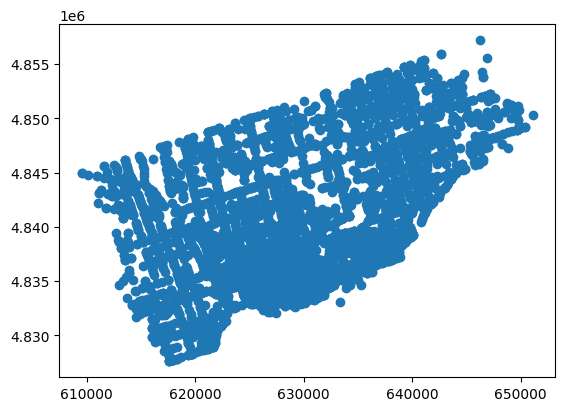

In [120]:
#keep only data we need
traffic_collision = combined[['year', 'location_id', 'HOOD_1512', 'NEIGHBO13', 'centreline_id', 'motorcol', 'fatals', 'injuries']]

#add the collision data back into traffic data using the new shared ids
format_traf_col = auto_traffic_agg.merge(traffic_collision, how='left', on=['year', 'location_id'], validate='1:m', suffixes=('_l', '_r'))

#aggregate by year and location id once more to combine collision data together on the same location
#the function grabs the first value in a dataframe, since we dont care which we grab when aggregating.
def first_val(x):
    return x.iloc[0]

col_traf_agg = format_traf_col.groupby(['year','location_id']).agg({'count_id': first_val,
                                                                    'location': first_val,
                                                                    'centreline_id_r': first_val,
                                                                    'HOOD_1512': first_val,
                                                                    'NEIGHBO13': first_val,
                                                                    'nb_auto': 'sum',
                                                                    'eb_auto': 'sum',
                                                                    'sb_auto': 'sum',
                                                                    'wb_auto': 'sum',
                                                                    'total_auto': 'sum',
                                                                    'motorcol':'sum',
                                                                    'fatals':'sum',
                                                                    'injuries': 'sum',
                                                                    'geometry': first_val})
#reset to remove groups
col_traf_agg = col_traf_agg.reset_index()
#fix formatting
col_traf_agg = col_traf_agg.rename(columns={'centreline_id_r':'centreline_id'})

#our new data
traffic_collision = gpd.GeoDataFrame(col_traf_agg)
traffic_collision = traffic_collision.set_crs(epsg=26917)

#checking to see we still have data after the merge
col_traf_map = traffic_collision.query('total_auto > 0 & motorcol > 0')
col_traf_map.plot()

## Finding the cardinal directions around an intersection

Our first step in finding which road around an intersection corresponds to which direction  
is to first grab our intersection data, traffic_collision, and create a buffer around each point.

The reason for doing so is that we can then spatial join any road within that buffer to the intersection  
data, allowing us to know which intersection a road belongs too. If a road touched multiple intersections  
then there will be multiple copies of the road we have to combine later.

Another reason for the buffer is in case the road lines don't touch the intersection point, so this allows  
for some margin of error in the geometry.

In [141]:
#copy traffic points
traffic_collision_buffer = traffic_collision.copy()
#create a buffer around them
traffic_collision_buffer['geometry'] = traffic_collision_buffer.buffer(4)
traffic_collision_buffer.head()

,year,location_id,count_id,location,centreline_id,HOOD_1512,NEIGHBO13,nb_auto,eb_auto,sb_auto,wb_auto,total_auto,motorcol,fatals,injuries,geometry
0,2010,3938,26267,DON VALLEY PKWY AT WYNFORD DR WTCS (PX 1037),13453914.0,NaN,NaN,0.0,4526.0,4743.0,2666.0,11935.0,0.0,0.0,0.0,"POLYGON ((634437.181 4842868.761, 634437.161 4..."
1,2010,3940,25879,BLACK CREEK DR AT LAWRENCE AVE W (PX 1348),13457600.0,NaN,NaN,11872.0,5798.0,12795.0,12439.0,42904.0,0.0,0.0,0.0,"POLYGON ((621335.871 4840204.966, 621335.851 4..."
2,2010,3946,25409,BIRCHCLIFF AVE AT KINGSTON RD,13459344.0,NaN,NaN,303.0,5987.0,423.0,5850.0,12563.0,0.0,0.0,0.0,"POLYGON ((639845.858 4839070.104, 639845.839 4..."
3,2010,3948,26099,KINGSTON RD AT MIDLAND AVE,13456025.0,NaN,NaN,2557.0,7692.0,2414.0,8350.0,21013.0,0.0,0.0,0.0,"POLYGON ((641134.713 4841279.651, 641134.694 4..."
4,2010,3949,26317,CHINE DR AT KINGSTON RD,13455525.0,NaN,NaN,260.0,8217.0,323.0,8621.0,17421.0,0.0,0.0,0.0,"POLYGON ((641378.572 4841617.367, 641378.553 4..."


We combined the roads with the buffer to get our new roads. For each road we convert it into a centroid,  
roads_points, the point in the middle of each road. This will allow us to get its coordinates, and since each  
road is tied to an intersection we can compare the coordinates of each intersections group of roads to  
find which one is furthest North, East, South, and West.

roads_with_data is then combined back into a single road per year,  
but summing up its total count for collisons, and traffic. This way we know  
what the total count for surrounding intersections was.

In [191]:
#join every intersection with the roads that surrond it
roads_with_data = traffic_collision_buffer.sjoin(road_26917, how='right')

#with the roads we have now with intersection data, turn them to centroids
road_points = roads_with_data.copy()
road_points['geometry'] = roads_with_data.centroid
road_points['x'] = road_points['geometry'].x
road_points['y'] = road_points['geometry'].y

roads_with_data = roads_with_data.drop(columns=['nb_auto', 'eb_auto', 'sb_auto', 'wb_auto','location_id'])
roads_with_data['road_count'] = 0 #init the running count for this road

#return first value since we are not summing, but combining the same roads
def first_val(x):
    return x.iloc[0]

#combine all of the same roads, since we got multiples fromm the sjoin
#roads would have multiple copies if they touched multiple intersections
roads_with_data = roads_with_data.groupby(['year','CENTREL2']).agg({
    'LINEAR_4':first_val,
    'LINEAR_5': first_val,
    'FEATURE36': first_val,
    'road_count': first_val,
    'total_auto': 'sum', #sum this, so we get a count of all traffic from intersections surrounding the road
    'motorcol': 'sum', #this needs to be added, since different intersections will give a road different collisions
    'fatals': 'sum',
    'injuries': 'sum',
    'calm_id': first_val,
    'spd_hump': first_val,
    'traf_islan': first_val,
    'spd_cush': first_val,
    'Installed': first_val,
    'geometry': first_val})
roads_with_data = roads_with_data.reset_index()
roads_with_data = gpd.GeoDataFrame(roads_with_data)
roads_with_data = roads_with_data.set_crs(epsg=26917)
roads_with_data.head(-5)


,year,CENTREL2,LINEAR_4,LINEAR_5,FEATURE36,road_count,total_auto,motorcol,fatals,injuries,calm_id,spd_hump,traf_islan,spd_cush,Installed,geometry
0,2010.0,211,Victoria Park Ave,Victoria Park Avenue,Major Arterial,0,11481.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637106.781 4841491.113, 637080.257..."
1,2010.0,230,Victoria Park Ave,Victoria Park Avenue,Major Arterial,0,11481.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637131.082 4841418.18, 637106.781 ..."
2,2010.0,267,Brentcliffe Rd,Brentcliffe Road,Minor Arterial,0,10837.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (632192.387 4841289.277, 632158.265..."
3,2010.0,310,Adair Rd,Adair Road,Local,0,379.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637008.807 4841174.812, 637190.775..."
4,2010.0,311,Glenburn Ave,Glenburn Avenue,Local,0,379.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637008.807 4841174.812, 636985.654..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31227,2024.0,30155269,Mossom Rd,Mossom Road,Local,0,842.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (622081.46 4833736.194, 622088.521 ..."
31228,2024.0,60000100,The Pond Rd,The Pond Road,Minor Arterial,0,9611.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (620860.021 4847523.735, 620978.814..."
31229,2024.0,60000529,St Dennis Eglinton E Ramp,St Dennis Eglinton E Ramp,Major Arterial Ramp,0,10530.0,17.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634937.546 4842549.101, 634953.268..."
31230,2024.0,60000544,St Dennis Eglinton E Ramp,St Dennis Eglinton E Ramp,Major Arterial Ramp,0,25861.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634972.659 4842569.903, 634990.681..."


### Cardinal Directions

The actual process of finding the roads for each intersection and finding which one belongs  
to which direction can be a bit involed, but it will be broken down step by step:

- First each point that represents a road is grouped by year. That way we can repeat this  
process for each years worth of data.

- Then for each year we group the roads by their intersection via location_id.

- For each group of roads sharing a location_id we use their centroid coordinates to  
find the Max and Min of X and Y. This lets us know which roads are furtherst in which direction.

- We assign cardinal directions to each roads data

- For each direction, we use its unique identifier to find the same road in road_data

- We grab the directional roads associated data for the year (The north roads data would be "nb_auto" for example)  
and add that to the road in road_data's traffic count for the same year. In this way a road with multiple intersections  
would eventually have all the directional data associated with it from surrounding intersections. 

In [198]:
#this wont make a new shape file, rather it is updating roads_with_data with the 
#traffic data from the intersection that surround a road

#split the roads and points by year
point_split = {k:d for k, d in road_points.groupby('year')}

#for each year
for year in point_split:
    #we divide the road into groups that share the same intersection
    location_id = {k:d for k, d in point_split[year].groupby('location_id')}
    
    #and for each group
    for i in location_id:
        #turn the group into a datafram
        location = location_id[i]

        #find the road at each cardinal point around the intersection
        #first north, by selecting the road whose centroid is the furthest north
        north = location.loc[location['y'].idxmax()]
        #then south with minimum
        south = location.loc[location['y'].idxmin()]
        #same for east and west, but with x
        east = location.loc[location['x'].idxmax()]
        west = location.loc[location['x'].idxmin()]

        #put each road into a list
        direction = [north, south, east, west]
        #and the value we want from it
        values =['nb_auto', 'sb_auto', 'eb_auto', 'wb_auto']

        #then for each of these cardinal point roads we update the real matching road with an updated count
        for i in range(len(direction)):
            #which direction are we choosing, get the road id
            road_id = direction[i]['CENTREL2']

            #queries should only return one road since we aggregated on year and CENTREL2
           
            #get the current total traffic count from the real road so we can add to it
            cur_count = roads_with_data.loc[(roads_with_data['year'] == year) & (roads_with_data['CENTREL2'] == road_id)]['road_count']
            cur_count = cur_count.to_numpy()[0]
            #update the road with its current count + the count from the directional data
            roads_with_data.loc[(roads_with_data['year'] == year) & (roads_with_data['CENTREL2'] == road_id),['road_count']] = cur_count + direction[i][values[i]]


,year,CENTREL2,LINEAR_4,LINEAR_5,FEATURE36,road_count,total_auto,motorcol,fatals,injuries,calm_id,spd_hump,traf_islan,spd_cush,Installed,geometry
0,2010.0,211,Victoria Park Ave,Victoria Park Avenue,Major Arterial,5391,11481.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637106.781 4841491.113, 637080.257..."
1,2010.0,230,Victoria Park Ave,Victoria Park Avenue,Major Arterial,5326,11481.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637131.082 4841418.18, 637106.781 ..."
2,2010.0,267,Brentcliffe Rd,Brentcliffe Road,Minor Arterial,3732,10837.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (632192.387 4841289.277, 632158.265..."
3,2010.0,310,Adair Rd,Adair Road,Local,64,379.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637008.807 4841174.812, 637190.775..."
4,2010.0,311,Glenburn Ave,Glenburn Avenue,Local,154,379.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637008.807 4841174.812, 636985.654..."


Here we check the data of a random road and see that the road_count, the traffic that it saw, is less than total_auto, the sum of all traffic  
from surrounding intersections. In our previous analysis we assumed that road_count = total_auto.

We assumed road_count = total_auto only because collision data itself does not have directional for which road a collision occured.

In [201]:
roads_with_data.query('CENTREL2 == 444094')

,year,CENTREL2,LINEAR_4,LINEAR_5,FEATURE36,road_count,total_auto,motorcol,fatals,injuries,calm_id,spd_hump,traf_islan,spd_cush,Installed,geometry
629,2010.0,444094,Wynford Dr,Wynford Drive,Minor Arterial,7409,11935.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634231.717 4842749.23, 634241.968 ..."
6506,2013.0,444094,Wynford Dr,Wynford Drive,Minor Arterial,3551,7720.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634231.717 4842749.23, 634241.968 ..."
13957,2017.0,444094,Wynford Dr,Wynford Drive,Minor Arterial,4147,8804.0,15.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634231.717 4842749.23, 634241.968 ..."
29917,2024.0,444094,Wynford Dr,Wynford Drive,Minor Arterial,6504,10259.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634231.717 4842749.23, 634241.968 ..."


## How To Associate Road Data with Collision data?

Our previous analysis was flawed due to the assumptioned mentioned above, but how do we fix that?

One method comes to mind:
- assume that the ratio of roads traffic / surrounding traffic = roads collisions / surrounding collision

All the variables we have except for a roads personal collision count, which we can then find.

Before, when road traffic was equal to all surrounding traffic, roads that neighboured roads with lots of traffic  
were unevenlly affected. However in this case we use only a ratio. The only assumpotion here is that the ratio  
of traffic to collision is the same for every road. And while this is most likely not the case, each road is less  
affected by its neighbour.

We also find a roads collision rate with this new information, a roads traffic / a roads collisons

In [207]:
#find a roads personal collision count by assuming the ratio is the same for traffic/surrounding traffic
#we solve for one side of the equation, isolating a roads collision
roads_with_data['road_col'] = (roads_with_data['road_count'] * roads_with_data['motorcol']) / roads_with_data['total_auto']

#now find the collison rate per 100,000, rounded to the nearest 1000ths
roads_with_data['col_rate'] = round(roads_with_data['road_col'] / roads_with_data['road_count'] * 100000, 3)

#reorder the columns so geometry is last
column_to_move = roads_with_data.pop('road_col')
# insert column with insert(location, column_name, column_value)
roads_with_data.insert(6, 'road_col', column_to_move)

column_to_move = roads_with_data.pop('col_rate')
# insert column with insert(location, column_name, column_value)
roads_with_data.insert(7, 'col_rate', column_to_move)

#check our new columns
roads_with_data.head(-5)


,year,CENTREL2,LINEAR_4,LINEAR_5,FEATURE36,road_count,road_col,col_rate,total_auto,motorcol,fatals,injuries,calm_id,spd_hump,traf_islan,spd_cush,Installed,geometry
0,2010.0,211,Victoria Park Ave,Victoria Park Avenue,Major Arterial,5391,0.000000,0.000,11481.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637106.781 4841491.113, 637080.257..."
1,2010.0,230,Victoria Park Ave,Victoria Park Avenue,Major Arterial,5326,0.000000,0.000,11481.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637131.082 4841418.18, 637106.781 ..."
2,2010.0,267,Brentcliffe Rd,Brentcliffe Road,Minor Arterial,3732,0.000000,0.000,10837.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (632192.387 4841289.277, 632158.265..."
3,2010.0,310,Adair Rd,Adair Road,Local,64,0.000000,0.000,379.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637008.807 4841174.812, 637190.775..."
4,2010.0,311,Glenburn Ave,Glenburn Avenue,Local,154,0.000000,0.000,379.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (637008.807 4841174.812, 636985.654..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31227,2024.0,30155269,Mossom Rd,Mossom Road,Local,328,0.000000,0.000,842.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (622081.46 4833736.194, 622088.521 ..."
31228,2024.0,60000100,The Pond Rd,The Pond Road,Minor Arterial,6376,0.663407,10.405,9611.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (620860.021 4847523.735, 620978.814..."
31229,2024.0,60000529,St Dennis Eglinton E Ramp,St Dennis Eglinton E Ramp,Major Arterial Ramp,548,0.884710,161.443,10530.0,17.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634937.546 4842549.101, 634953.268..."
31230,2024.0,60000544,St Dennis Eglinton E Ramp,St Dennis Eglinton E Ramp,Major Arterial Ramp,800,0.000000,0.000,25861.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"LINESTRING (634972.659 4842569.903, 634990.681..."


Save our work for later use

In [258]:
roads_with_data.to_file('roads_with_data.shp')

# Analysis

We will perform the same analysis as previously, and see if there is any change in the outcome.  
Again, we split the data by roads without calming features and those with it.

In [259]:
#return only normal roads and format dataframe
normal_roads = roads_with_data.query('year == 2023 & Installed.isna()')
normal_roads['type'] = 'normal'

#return only calmed roads and format dataframe
calmed_roads = roads_with_data.query('year == 2023 & Installed <= 2023')
calmed_roads['type'] = 'calmed'

#dataframes for the matplot
normal_data = normal_roads[['col_rate', 'type']].dropna()
calm_data = calmed_roads[['col_rate', 'type']].dropna()
#combined if needed
data = pd.concat([normal_data, calm_data])


In [260]:
data.groupby('type').describe()

col_rate                                                       \
          count       mean         std  min     25%     50%      75%   
type                                                                   
calmed     29.0  58.816931  159.878617  0.0   0.000  24.567   34.746   
normal   2073.0  96.112023  458.727612  0.0  15.335  52.268  108.303   

                   
              max  
type               
calmed    862.069  
normal  13413.174

In [261]:
#set our graph style
sns.set_style('whitegrid')

(0.0, 1600.0)

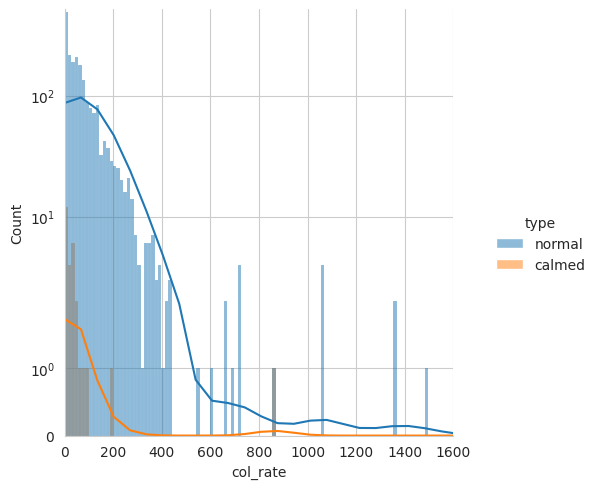

In [262]:
sns.displot(data=data, x="col_rate",hue='type', kde=True)
plt.yscale("symlog")
plt.xlim(0, 1600)

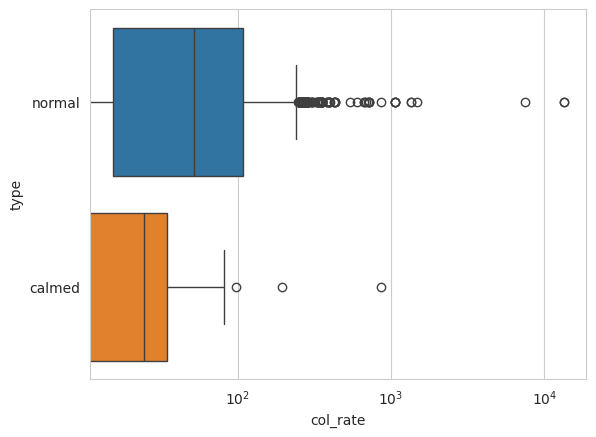

In [263]:
ax = sns.boxplot(x='col_rate',y='type', hue=data['type'],data=data)
plt.xscale('log')

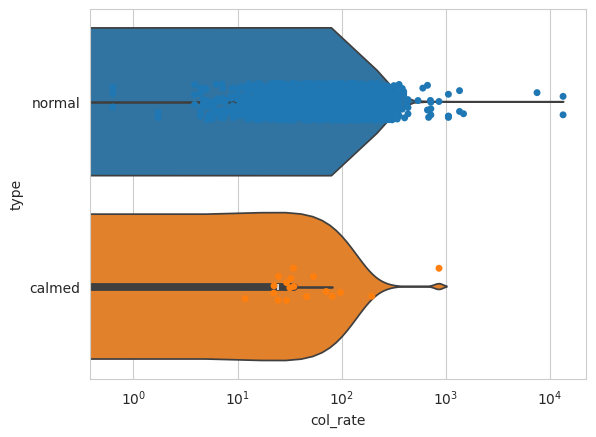

In [264]:
ax = sns.violinplot(x='col_rate',y='type', hue=data['type'], data=data)
ax = sns.stripplot(x='col_rate',y='type', hue=data['type'], data=data)
plt.xscale('log')

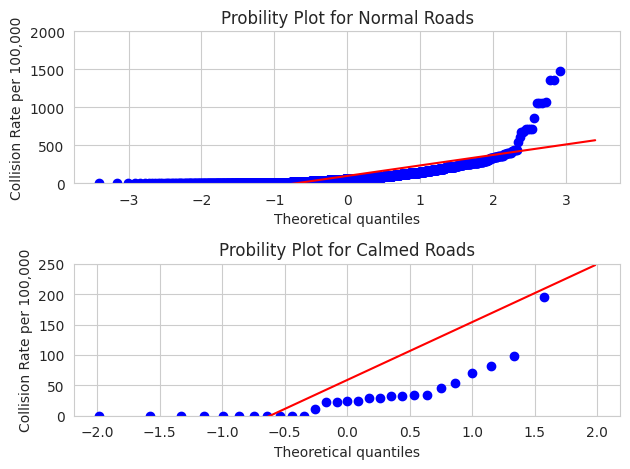

In [265]:
ax1 = plt.subplot(211)
res = scipy.stats.probplot(normal_data['col_rate'], plot=plt, fit=True) 

ax2 = plt.subplot(212)
res2 = scipy.stats.probplot(calm_data['col_rate'], plot=plt, fit=True)

ax1.set_title("Probility Plot for Normal Roads")
ax1.set_ylabel('Collision Rate per 100,000')

ax2.set_title("Probility Plot for Calmed Roads")
ax2.set_ylabel('Collision Rate per 100,000')

ax1.set_ylim([0, 2000]) #to zoom in and see data
ax2.set_ylim([0, 250]) #to zoom in and see data

plt.tight_layout()

In [266]:
alpha= 0.05

#drop NaN to avoid error
t_statistic, p_value = pystat.ttest_ind(normal_data['col_rate'], calm_data['col_rate'], alternative='greater', equal_var=False)


# Output the results
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("There is a significant difference between the collison rates.")
else:
    print("There is no significant difference between the collsion rates.")

t-statistic: 1.18957097141484
P-value: 0.12113241509284904
There is no significant difference between the collsion rates.



## Results

Once again, visually the distribution of collision rates between road types appear to be similar,  
which is again confirmed by the two sample t-test. However this is expected due to the methodoloy used  
to retrieve the collison data. By assuming each roads collision count is tied to it's traffic count we  
essentially normalized all roads, regardless of type. 

But instead of assuming collision is based on traffic count, what if we base it on road type? Lets say that  
regardless whether a road has a calming feature or not, what matters is the classification of the road.  
E.g, 'Local', 'Major Arterial', 'Major Arterial Ramp', 'Collector', 'Collector Ramp', 'Minor Arterial', 'Minor Arterial Ramp'

Each road will instead account for a percentage of surrounding collision, but how do we find that percentage?  
How about if we divided the roads into major and minor roads? Collectors will be considered minor, as their job  
is to provide access to residential properties. And then we summed up the traffic and collisions for all major and  
all minor, to find the overall ratios.


In [276]:
#create a copy of the road data
roads_data_class = roads_with_data.copy()
#create new column for sub classification
roads_data_class['class'] = None

#create a list of all the classifications used
major = ['Major Arterial', 'Major Arterial Ramp']
minor = ['Local', 'Collector', 'Collector Ramp', 'Minor Arterial', 'Minor Arterial Ramp']
#for each type in the list, create assign value major or minor

#simple function to return subclassification
def class_check(row):
    if row in minor:
        return 'minor'
    else:
        return 'major'


roads_data_class['class'] = 

roads_data_class.head()

TypeError: <lambda>() got an unexpected keyword argument 'axis'

# Conclusion

Once again, visually the distribution of collision rates between road types appear to be similar,  
which is again confirmed by the two sample t-test. However this is expected due to the methodoloy used  
to retrieve the collison data. By assuming each roads collision count is tied to it's traffic count we  
essentially normalized all roads, regardless of type. 

If we were to instead assume that certain road types had different ratios of collisions to surrounding  
collisions, then we would instead be asserting our own conclusion while creating the data. For example,  
if we assumed calmed roads accounted for 2% of surrounding collisions while normal roads accounted for 3%  
of surrounding collisions then our t-test would assert that the two road types have different means for rates  
of collision, which of course they would because